In [1]:
import sys

import numpy as np
import gym
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()

from matplotlib import rc

sns.set(rc={'figure.figsize': (15, 8),
           'legend.fontsize': 16})

### 1.1 Simple strategy 
Делаем HIT пока сумма на руке меньше 19. Оцениваем с помощью Monte Carlo First Visit

In [329]:
HIT, STAND = 1, 0

def simple_policy(obs):
    sum_hand, dealer_first, usable_ace = obs
    return HIT if sum_hand < 19 else STAND

# sum_hand, dealer_first, usable_ace = env.reset()
def run_episode(env, policy):
    states, actions, rewards = [], [], []
    obs = env.reset()
    done = False
    while not done:
        states.append(obs)
        action = policy(obs)
        actions.append(action)
        obs, reward, done, _ = env.step(action)
        rewards.append(reward)
    return states, actions, rewards

def first_visit_mc_prediction(env, policy, n_episodes, gamma=1.0):
    value_table = defaultdict(float)
    N = defaultdict(int)
    all_rewards = np.zeros(n_episodes)
    
    for i in range(n_episodes):
        states, _, rewards = run_episode(env, policy)
        returns = 0
        for j, t in enumerate(range(len(states) - 1, -1, -1)):
            R = rewards[t]
            S = states[t]
            # discount reward
            returns += (gamma**j) * R
            if S not in states[:t]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
        
        all_rewards[i] = rewards[-1]    
    return value_table, all_rewards

In [311]:
def plot_mean_reward(rewards):
    mean_rewards = [cs / (i+1) for i, cs in enumerate(np.cumsum(rewards))]
    plt.plot(mean_rewards, label=f'mean return = {np.mean(rewards)}')
    plt.legend(loc='lower right', shadow=True, fontsize='x-large')
    plt.xlabel('Episode')
    plt.ylabel('Mean return')
    plt.show()

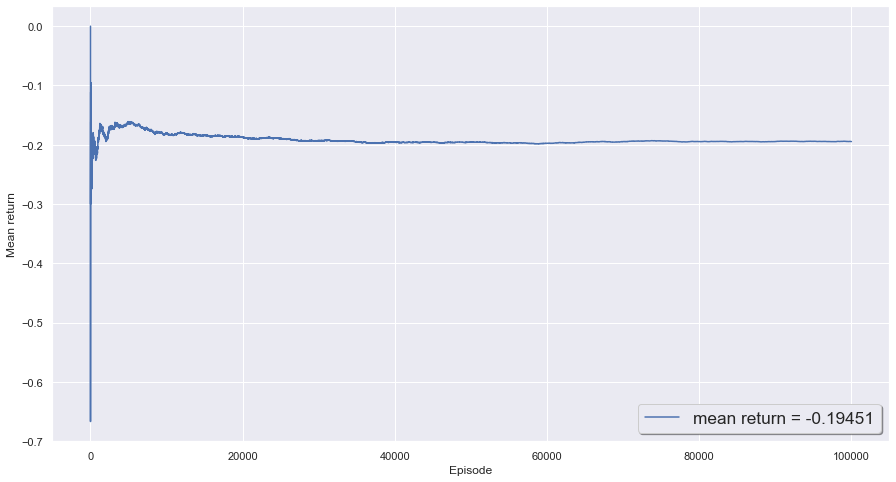

CPU times: user 4.27 s, sys: 42.7 ms, total: 4.31 s
Wall time: 4.34 s


In [330]:
%%time
env = gym.make('Blackjack-v1', natural=True)
_, rewards = first_visit_mc_prediction(env, simple_policy, n_episodes=100_000)
plot_mean_reward(rewards)

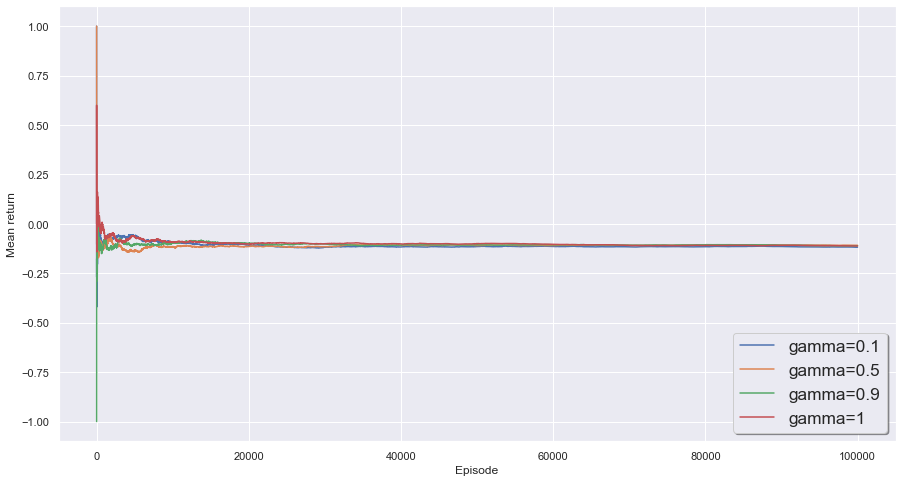

In [27]:
# # maybe we don't need gammas becuase of constant policy????

# def plot_results(env, gammas_to_try=[.1, .5, .9, 1]):
#     max_reward = -1
#     for g in gammas_to_try:
#         _, mean_returns = first_visit_mc_prediction(env, simple_policy, n_episodes=100_000, gamma=g)
#         plt.plot(mean_returns, label=f'gamma={g}')
#         max_reward = max(np.mean(mean_returns), max_reward)
#     plt.xlabel('Episode')
#     plt.ylabel('Mean return')
#     plt.legend(loc='lower right', shadow=True, fontsize='x-large')
#     plt.show()
#     print(f'reward: {max_reward}' )
    
# plot_results(env)

### 1.2 Finding best strategy

используем on-policy first visit Monte Carlo Control

In [328]:
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s


def update_Q(env, episode, Q, alpha, gamma):
    for s, a, r in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])
    return Q


def run_episode(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    done = False
    while not done:
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode


def mc_control(env, n_episodes, epsilon = .1, gamma = 1.0, alpha = .001):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    rewards = np.zeros(n_episodes)
    for i in range(n_episodes):
        if (i + 1) % 1000 == 0:
            print(f"\rEpisode {i + 1}/{n_episodes}", end="")
            sys.stdout.flush()
        
        episode = run_episode(env, Q, epsilon, nA)
        rewards[i] = episode[-1][-1]
        Q = update_Q(env, episode, Q, alpha, gamma)
    
    # final best actions for each Q value
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, rewards

Episode 100000/100000

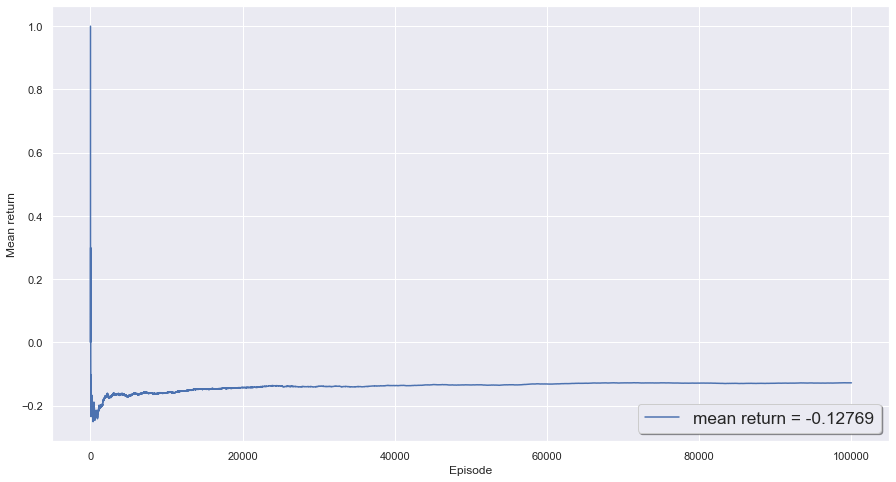

CPU times: user 11.1 s, sys: 1.14 s, total: 12.2 s
Wall time: 11.3 s


In [299]:
%%time
env = gym.make('Blackjack-v1', natural=True)
_, _, rewards_mc = mc_control(env, 100_000)
plot_mean_reward(rewards_mc)

In [305]:
def tune_g_and_e(env, n_episodes=10_000):
    gammas = np.arange(.1, 1.1, .1)
    epsilons = np.arange(.05, .21, .05)

    max_reward = -1
    for g in gammas:
        for e in epsilons:
            _, _, rewards = mc_control(env, n_episodes, gamma=g, epsilon=e, alpha=.01)
            if np.mean(rewards) > max_reward:
                max_reward = np.mean(rewards)
                best_g, best_e = g, e
                print(f'mean reward: {max_reward}, gamma={g}, eps={e}')
    return best_g, best_e

def tune_alpha(env, g, e, n_episodes=10_000):
    alphas = np.arange(.001, .15, .005)
    max_reward = -1
    for a in alphas:
        _, _, rewards = mc_control(env, n_episodes, epsilon=e, gamma=g, alpha=a)
        if np.mean(rewards) > max_reward:
            max_reward = np.mean(rewards)
            best_a = a
            print(f'mean reward: {max_reward}, alpha={a}')
    return best_a

In [308]:
def plot_policy(policy):

    def get_Z(player_hand, dealer_showing, usable_ace):
        if (player_hand, dealer_showing, usable_ace) in policy:
            return policy[player_hand, dealer_showing, usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.invert_yaxis() 
            
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

In [306]:
%%time
best_g, best_e = tune_g_and_e(env)
best_a = tune_alpha(env, best_g, best_e, 30_000)

Episode 10000/10000mean reward: -0.098, gamma=0.1, eps=0.05
Episode 30000/30000mean reward: -0.09743333333333333, alpha=0.001
Episode 30000/30000mean reward: -0.08296666666666666, alpha=0.021
Episode 30000/30000mean reward: -0.08136666666666667, alpha=0.041
Episode 30000/30000mean reward: -0.07436666666666666, alpha=0.066
Episode 30000/30000CPU times: user 2min 31s, sys: 16.4 s, total: 2min 48s
Wall time: 2min 35s


Episode 100000/100000

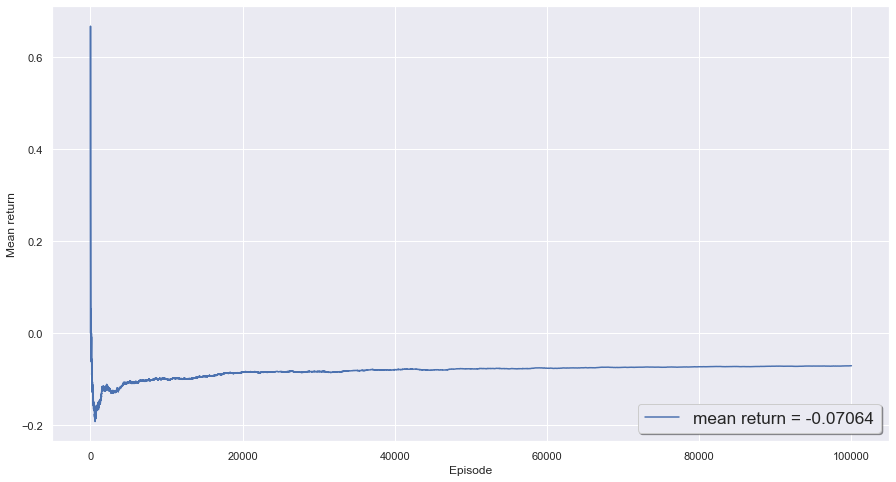

CPU times: user 11.9 s, sys: 1.22 s, total: 13.1 s
Wall time: 12.2 s


In [312]:
%%time
policy, Q, rewards = mc_control(env, 100_000, epsilon=best_e, gamma=best_g, alpha=best_a)
plot_mean_reward(rewards)

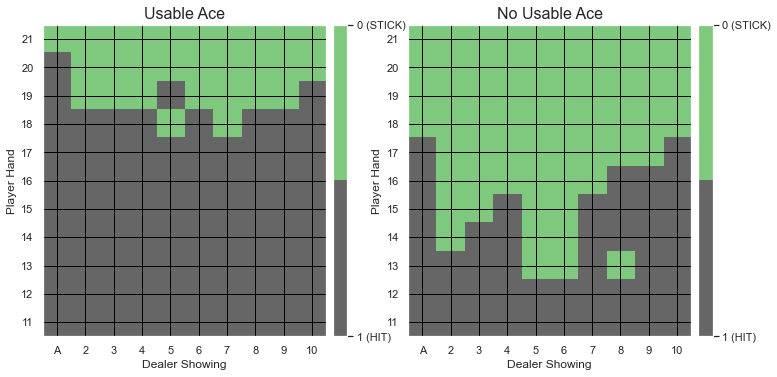

In [309]:
plot_policy(policy)

Улучшили среднюю награду по сравнению с константной политикой примерно на 13%. Теперь попробуем обновить среду блэкджека дополнительными действиями и состояниями

### Doubling

Новое действие - возможность удваивать ставку. Добавим итераций, т.к. теперь у нас увеличилась Q-таблица

In [279]:
from blackjack_w_double import BlackjackEnv

Episode 1000000/1000000

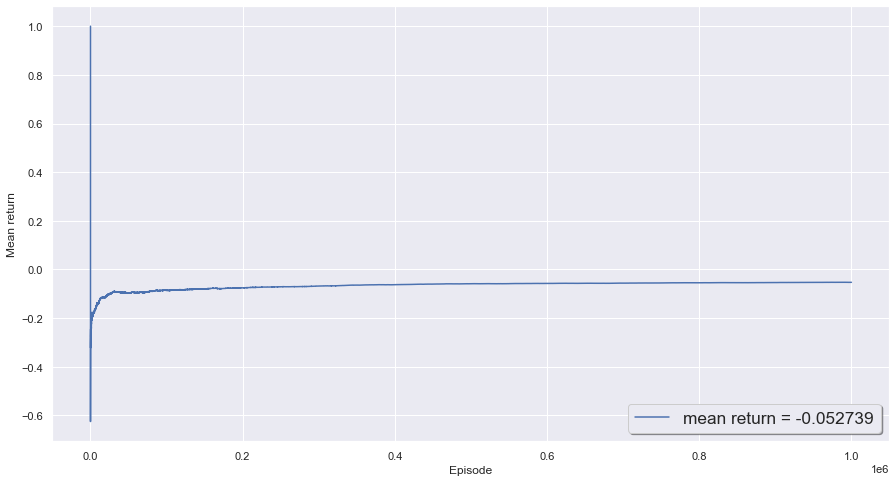

In [314]:
%%time
env2 = BlackjackEnv(natural=True)
policy, Q, rewards = mc_control(env2, 1_000_000, gamma=best_g, epsilon=best_e, alpha=.005)
plot_mean_reward(rewards)

In [316]:
%%time
best_g, best_e = tune_g_and_e(env2)
best_a = tune_alpha(env2, best_g, best_e, 30_000)

Episode 10000/10000mean reward: -0.1425, gamma=0.1, eps=0.05
Episode 10000/10000mean reward: -0.1423, gamma=0.1, eps=0.1
Episode 10000/10000mean reward: -0.1257, gamma=0.2, eps=0.05
Episode 10000/10000mean reward: -0.11215, gamma=0.4, eps=0.05
Episode 30000/30000mean reward: -0.12583333333333332, alpha=0.001
Episode 30000/30000mean reward: -0.10953333333333333, alpha=0.006
Episode 30000/30000mean reward: -0.10583333333333333, alpha=0.016
Episode 30000/30000mean reward: -0.08768333333333334, alpha=0.026000000000000002
Episode 30000/30000mean reward: -0.08641666666666667, alpha=0.031
Episode 30000/30000mean reward: -0.08543333333333333, alpha=0.08600000000000001
Episode 30000/30000mean reward: -0.0833, alpha=0.111
Episode 30000/30000mean reward: -0.08306666666666666, alpha=0.136
Episode 30000/30000CPU times: user 2min 30s, sys: 21.2 s, total: 2min 51s
Wall time: 2min 34s


In [317]:
# plotting policy with additional action (DOUBLE)
def plot_policy2(policy):

    def get_Z(player_hand, dealer_showing, usable_ace):
        if (player_hand, dealer_showing, usable_ace) in policy:
            return policy[player_hand, dealer_showing, usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 3), vmin=0, vmax=2, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1, 2], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)', '2 (DOUBLE)'])
        cbar.ax.invert_yaxis() 
            
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

Episode 1000000/1000000

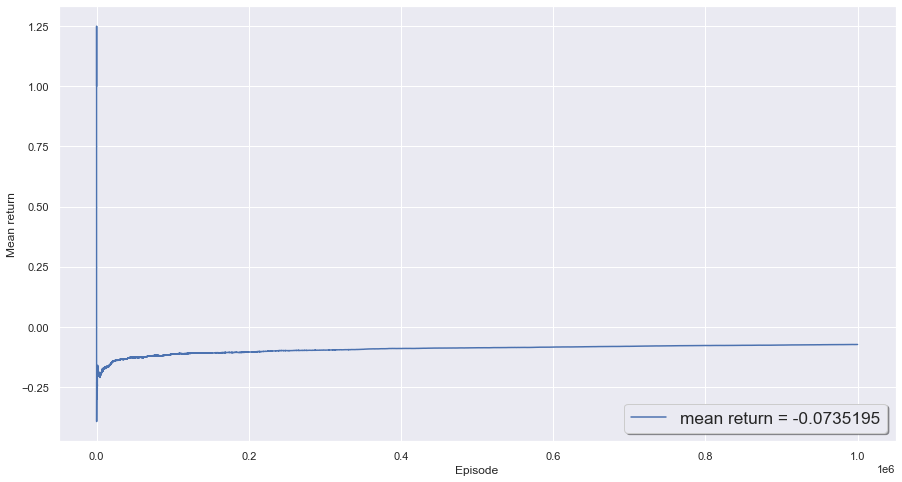

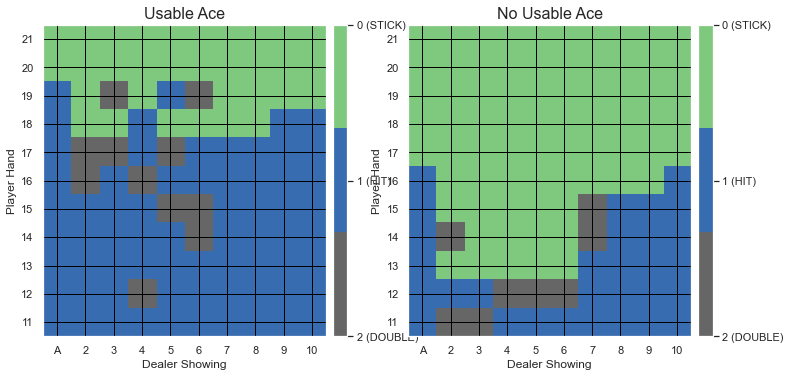

CPU times: user 1min 58s, sys: 16.7 s, total: 2min 15s
Wall time: 2min 2s


In [319]:
%%time
policy, Q, rewards = mc_control(env2, 1_000_000, gamma=best_g, epsilon=best_e, alpha=best_a)
plot_mean_reward(rewards)
plot_policy2(policy)

Почему-то смогли улучшить предыдущий результат только на предыдущих гиперпараметрах (возможно, имеют место некоторые колебания из-за большого влияния случайности)

### Counting

Новые состояния - счетчик сыгранных карт (реализовано два метода: "Плюс-Минус" и "Половинки". Половинки дают лучшее мат ожидание выигрыша, так что будем использовать их. Снова увеличим кол-во итераций, т.к. теперь состояний стало еще больше

In [253]:
# from importlib import reload  
# blackjack_w_count = reload(blackjack_w_count)

In [260]:
import blackjack_w_count

Episode 10000000/10000000

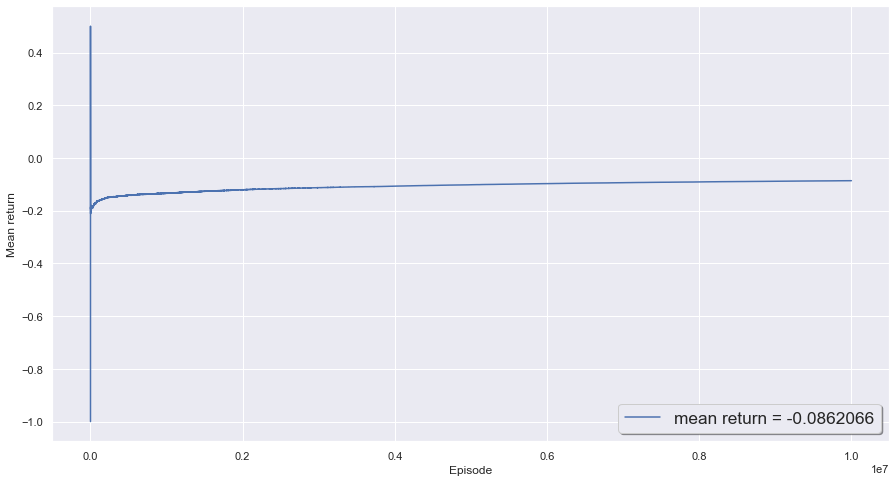

CPU times: user 20min 20s, sys: 2min 29s, total: 22min 49s
Wall time: 20min 53s


In [320]:
%%time
env3 = blackjack_w_count.BlackjackEnv(natural=True, cnt_method='halves')
policy, Q, rewards = mc_control(env3, 10_000_000)
plot_mean_reward(rewards)

Скорее всего нет особого смысла настраивать learning rate (alpha)

In [326]:
%%time
env3 = blackjack_w_count.BlackjackEnv(natural=True, cnt_method='halves')
best_g, best_e = tune_g_and_e(env3, 50_000)
# best_a = tune_alpha(env3, best_g, best_e, 30_000)

Episode 50000/50000mean reward: -0.15154, gamma=0.1, eps=0.05
Episode 50000/50000mean reward: -0.15084, gamma=0.2, eps=0.05
Episode 50000/50000mean reward: -0.1379, gamma=0.30000000000000004, eps=0.05
Episode 50000/50000CPU times: user 3min 56s, sys: 28.1 s, total: 4min 25s
Wall time: 4min 2s


Episode 10000000/10000000

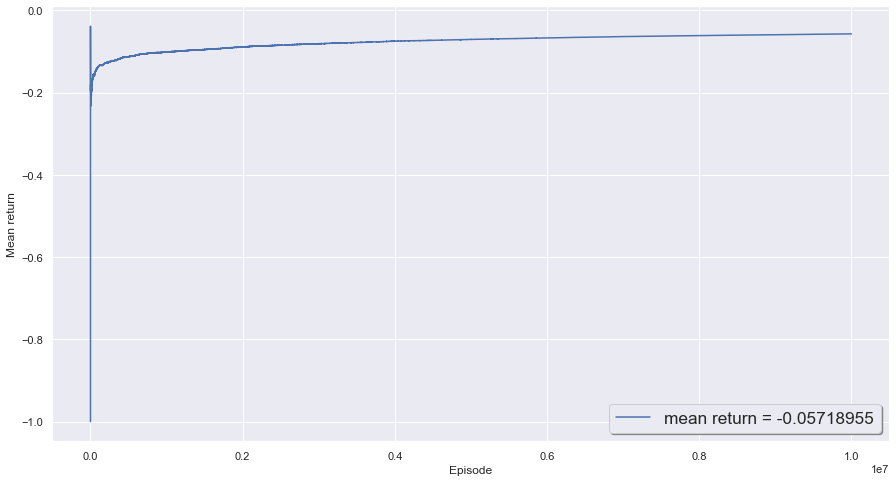

CPU times: user 21min 57s, sys: 2min 44s, total: 24min 41s
Wall time: 22min 35s


In [327]:
%%time
env3 = blackjack_w_count.BlackjackEnvDC(natural=True, cnt_method='halves')
policy, Q, rewards = mc_control(env3, 10_000_000, gamma=best_g, epsilon=best_e)
plot_mean_reward(rewards)

Получили результат близкий к варианту с удвоением. Возможно, при более тщательном подборе гиперпараметров (например с оценкой хотя бы после миллиона итераций), удалось бы еще сильнее приблизиться к нулю 